# Práctica 2

Procesamiento de Lenguaje Natural
Facultad de Ingeniería, UNAM

González Flores Andrés

## Instrucciones

A partir del corpus proporcionado ("corpusML.txt") realizar un modelo del lenguaje neuronal con base en la arquitectura propuesta por Bengio (2003).

Síganse los siguientes pasos:

1. Limpiar los textos y aplicar stemming a las palabras.
2. Insertar símbolos de inicio y final de cadena.
3. Obtener los bigramas que aparecen en el texto (indexar numéricamente).
4. Entrenar con los bigramas la red neuronal y obtener los valores para los hiperparámetros. Tomar de 100 unidades para la primera capa oculta (capa lineal) y 300 para la segunda capa oculta (capa con tanh).
5. Obtener las matrices $A$ y $\Pi$ a partir de las salidas de la red neuronal (probabilidad Softmax).
6. Evaluar el modelo (con Entropía).
7. Calcular la probabilidad de las siguientes oraciones:
    - Nos bañamos con agua caliente
    - El animalito le olía la cabeza
    - Pascuala ordeñaba las vacas

## Desarrollo

In [1]:
# Importar módulos
import numpy as np
import re
from nltk import SnowballStemmer
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import chain
from tqdm.notebook import tqdm as nbtqdm
from tqdm.auto import tqdm
import pandas as pd
from IPython.display import display

In [2]:
# Definición de constantes
SEED = 420
stemmer_esp = SnowballStemmer('spanish')
CORPUS_PATH = './Data/corpusML.txt'
BOS = '<BOS>'
EOS = '<EOS>'
UNK = '<unk>'

np.random.seed(SEED)

### Paso 1. Limpieza de corpus

Limpiar los textos y aplicar stemming a las palabras.

In [3]:
with open(CORPUS_PATH, 'r', encoding='utf-8') as f:
    corpus = [
        list(map(lambda token: stemmer_esp.stem(token), # Mapeo cada token a su stem
            re.findall('[a-zA-zñáéíóúü]+', linea.lower()) # Devuelve una lista con todas las ocurrencias que coincidan con la regex
        ))
        for linea in f
    ]
    for docs in corpus[:5]:
        print(docs) # Muestro 5 ejemplos

['comenc', 'a', 'trabaj', 'y', 'me', 'peg', 'me', 'maltrat', 'con', 'chicot']
['mis', 'patron', 'me', 'peg', 'porqu', 'no', 'me', 'quer', 'apur', 'porqu', 'era', 'floj']
['por', 'eso', 'me', 'hab', 'peg']
['cuand', 'me', 'peg', 'ya', 'entonc', 'me', 'quit']
['pues', 'entonc', 'no', 'quis', 'trabaj']


Divido el corpus en entrenamiento y evaluación

In [4]:
train_corpus, eval_corpus = train_test_split(corpus, test_size=0.3)

print(f'\nTamaño del corpus de entrenamiento: {len(train_corpus)}')
print('Ejemplos:')
for docs in train_corpus[:5]:
        print(docs) # Muestro 5 ejemplos

print(f'\nTamaño del corpus de evaluación: {len(eval_corpus)}')
print('Ejemplos:')
for docs in eval_corpus[:5]:
        print(' ', docs) # Muestro 5 ejemplos


Tamaño del corpus de entrenamiento: 751
Ejemplos:
['per', 'pues', 'si', 'el', 'padr', 'del', 'hombr', 'quer', 'lo', 'iba', 'a', 'dej']
['hem', 'fabric', 'un', 'temascal', 'par', 'bañ']
['ni', 'par', 'el', 'jabon', 'encontr']
['mi', 'difunt', 'padrecit', 'fue', 'qui', 'me', 'cur']
['se', 'traslad', 'de', 'igual', 'maner', 'y', 'se', 'le', 'mov', 'el', 'pal']

Tamaño del corpus de evaluación: 323
Ejemplos:
  ['y', 'cuart', 'par', 'que', 'vay', 'dos', 'segund', 'palm']
  ['le', 'dig', 'pues', 'que', 'no', 'es', 'tu', 'tambor', 'le', 'dig']
  ['com', 'tambien', 'se', 'llen', 'de', 'agu']
  ['juan', 'se', 'cay', 'del', 'tech']
  ['sobr', 'un', 'refresquit', 'y', 'algo', 'de', 'vinit']


Muestro la curva de zipf

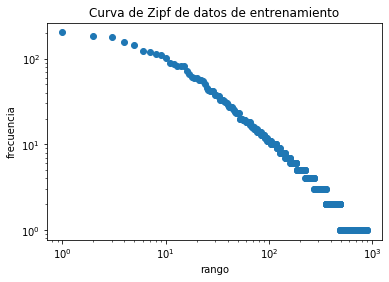

In [5]:
frec = sum([Counter(doc) for doc in train_corpus], Counter())

plt.plot(sorted(frec.values(), reverse=True), 'o')
plt.xlabel('rango')
plt.ylabel('frecuencia')
plt.xscale('log')
plt.yscale('log')
plt.title('Curva de Zipf de datos de entrenamiento')
plt.show()

Sustituyo los hapax por el identificador <unk\>

In [6]:
train_corpus_unk = [
    [
        # Si la frecuencia de la palabra es 1, se sustituye por UNK
        (UNK if frec[w] == 1 else w)
        for w in doc
    ] 
    for doc in train_corpus 
]

print('Ejemplos:')
for docs in train_corpus_unk[:5]:
        print(docs) # Muestro 5 ejemplos

Ejemplos:
['per', 'pues', 'si', 'el', 'padr', 'del', 'hombr', 'quer', 'lo', 'iba', 'a', 'dej']
['hem', 'fabric', 'un', 'temascal', 'par', 'bañ']
['ni', 'par', 'el', 'jabon', 'encontr']
['mi', 'difunt', 'padrecit', 'fue', 'qui', 'me', 'cur']
['se', 'traslad', 'de', 'igual', '<unk>', 'y', 'se', 'le', 'mov', 'el', 'pal']


### Paso 2. <BOS\> <EOS\>

Insertar símbolos de inicio y final de cadena.

In [7]:
train_corpus_unk = [[BOS] + doc + [EOS] for doc in train_corpus_unk]
for doc in train_corpus_unk[:5]:
    print(doc)

['<BOS>', 'per', 'pues', 'si', 'el', 'padr', 'del', 'hombr', 'quer', 'lo', 'iba', 'a', 'dej', '<EOS>']
['<BOS>', 'hem', 'fabric', 'un', 'temascal', 'par', 'bañ', '<EOS>']
['<BOS>', 'ni', 'par', 'el', 'jabon', 'encontr', '<EOS>']
['<BOS>', 'mi', 'difunt', 'padrecit', 'fue', 'qui', 'me', 'cur', '<EOS>']
['<BOS>', 'se', 'traslad', 'de', 'igual', '<unk>', 'y', 'se', 'le', 'mov', 'el', 'pal', '<EOS>']


### Paso 3. Indexar bigramas

Obtener los bigramas que aparecen en el texto (indexar numéricamente).

In [8]:
# Indexo numéricamente los stems
vocab = defaultdict() 
# El método default_factory sirve para asignar un nuevo valor por defecto
# en caso de no encontrar el indice dado
vocab.default_factory = lambda: len(vocab)

# Indexo EOS y BOS para que sean los primeros
i_BOS = vocab[BOS]
i_EOS = vocab[EOS]

# Indexo numéricamente las palabras en los documentos
corpus_ids = [[vocab[w] for w in doc] for doc in train_corpus_unk]

print('Ejemplos de palabras en el vocabulario')
for palabra, i in list(vocab.items())[:10]:
    print(f'  {palabra} : {i}')

print('\nEjemplos de oraciones indexadas numéricamente')
for doc in corpus_ids[:6]:
    print(' ', doc)

Ejemplos de palabras en el vocabulario
  <BOS> : 0
  <EOS> : 1
  per : 2
  pues : 3
  si : 4
  el : 5
  padr : 6
  del : 7
  hombr : 8
  quer : 9

Ejemplos de oraciones indexadas numéricamente
  [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1]
  [0, 14, 15, 16, 17, 18, 19, 1]
  [0, 20, 18, 5, 21, 22, 1]
  [0, 23, 24, 25, 26, 27, 28, 29, 1]
  [0, 30, 31, 32, 33, 34, 35, 30, 36, 37, 5, 38, 1]
  [0, 39, 40, 41, 42, 18, 43, 1]


Calculo el inverso del vocabulario, para obtener la palabra dado el índice.

In [9]:
inv_vocab = { item : key for key, item in vocab.items()}

```doc[:-1]``` toma todos las cadenas de un documento (frase) excepto la última

```doc[1:]``` toma todos las cadenas de un documento (frase) excepto la primera

Con zip, uno una cadena de la primer lista con una de la segunda en tuplas (bigramas)

In [10]:
bigramas = [bi for doc in train_corpus_unk for bi in zip(doc[:-1], doc[1:])]

bigramas[:20] # Ejemplos con cadenas

[('<BOS>', 'per'),
 ('per', 'pues'),
 ('pues', 'si'),
 ('si', 'el'),
 ('el', 'padr'),
 ('padr', 'del'),
 ('del', 'hombr'),
 ('hombr', 'quer'),
 ('quer', 'lo'),
 ('lo', 'iba'),
 ('iba', 'a'),
 ('a', 'dej'),
 ('dej', '<EOS>'),
 ('<BOS>', 'hem'),
 ('hem', 'fabric'),
 ('fabric', 'un'),
 ('un', 'temascal'),
 ('temascal', 'par'),
 ('par', 'bañ'),
 ('bañ', '<EOS>')]

Imprimo algunos de los bigramas más comunes en el corpus

In [11]:
counter_bigramas = Counter(bigramas)
counter_bigramas.most_common(15)

[(('<unk>', '<EOS>'), 114),
 (('<BOS>', 'pues'), 88),
 (('otra', 'vez'), 45),
 (('<BOS>', 'y'), 42),
 (('<BOS>', 'per'), 38),
 (('entonc', '<EOS>'), 36),
 (('<BOS>', 'se'), 35),
 (('el', '<unk>'), 29),
 (('nomas', '<EOS>'), 27),
 (('se', '<unk>'), 26),
 (('en', 'la'), 26),
 (('<BOS>', 'despues'), 25),
 (('<BOS>', 'no'), 25),
 (('<BOS>', 'lueg'), 25),
 (('par', 'que'), 25)]

In [12]:
bigramas_ids = [bi for doc in corpus_ids for bi in zip(doc[:-1], doc[1:])]
bigramas_ids[:20] # Ejemplos de bigramas indexados numéricamente

[(0, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (6, 7),
 (7, 8),
 (8, 9),
 (9, 10),
 (10, 11),
 (11, 12),
 (12, 13),
 (13, 1),
 (0, 14),
 (14, 15),
 (15, 16),
 (16, 17),
 (17, 18),
 (18, 19),
 (19, 1)]

### Paso 4. Modelo Neuronal

Entrenar con los bigramas la red neuronal y obtener los valores para los hiperparámetros. Tomar de 100 unidades para la primera capa oculta (capa lineal) y 300 para la segunda capa oculta (capa con tanh).

In [13]:
# Hiperparámetros
d = 100# 100
m = 300# 300
epochs = 25
lr = np.exp(-(np.arange(epochs)+1)/2) #0.01

# Constantes
N = len(vocab)
print('Tamaño del vocabulario: ', N)

Tamaño del vocabulario:  493


#### Definición del modelo

Defino la matriz de la primer capa oculta (embedding). $ C \in \mathbb{R}^{d \times N} $.

In [14]:
class Bengio2003:
    def __init__(self, bigramas, d, m, N):
        self.d = d
        self.m = m
        self.N = N
        self.bigramas = bigramas

    def inicializar_pesos(self):
        self.C = np.random.random((d, N))/np.sqrt(N)
        self.W = np.random.random((m, d))/np.sqrt(d)
        self.b = np.random.random(m)
        self.U = np.random.random((N, m))/np.sqrt(m)
        self.c = np.random.random(N)
        
        # Los mejores pesos del modelo
        self.best_C = self.C
        self.best_W = self.W
        self.best_b = self.b
        self.best_U = self.U
        self.best_c = self.c
    
    def forward(self, i_x):
        # La capa embedding se reduce a C_1[:, i_x]
        h_i = np.tanh(np.dot(self.W, self.C[:, i_x]) + self.b) # Segunda capa oculta
        a = self.U.dot(h_i) + self.c # Preactivación
        exp_a = np.exp(a - a.max()) # Exponencial de la preactivación
        prob_salida = exp_a/exp_a.sum() # Capa de salida softmax
        return prob_salida, h_i

    def backprop(self, i_x, i_y, prob_salida, h_i, lr=0.1):
        y_pred = np.argmax(prob_salida) # El índice de la palabra que predijo
        
        # Backprop
        # Copio el arreglo para no modificar pesos de la salida original
        d_out = np.array(prob_salida, copy=True) 
        d_out[i_y] -= 1  # p(w_k | w_i) - y_k
        d_h = (1-h_i**2)*np.dot(d_out.T, self.U)
        d_c = np.dot(d_h.T, self.W)

        # Actualizamos los pesos
        self.U -= lr*np.outer(d_out, h_i) 
        self.c -= lr*d_out
        self.W -= lr*np.outer(d_h, self.C[:,i_x]) 
        self.b -= lr*d_h
        self.C[:, i_x] -= lr*d_c # Las demás filas no nos interesan, porque son 0

    def predecir(self, i_x):
        return np.argmax(self.forward(i_x)[0])
    
    def entrenar(self, epochs=50, lr=[]):
        entr_timeline = [] # Entropía a través de las épocas
        min_entr = np.inf
        for epoch in nbtqdm(range(epochs)):
            np.random.shuffle(bigramas)
            cross_entropy = 0
            for bigrama in self.bigramas:
                i_x = bigrama[0] # El índice de la primer palabra del bigrama
                i_y = bigrama[1] # El índice de la segunda palabra del bigrama
                # print(f'  Bigrama: {inv_vocab[i_x]} {inv_vocab[i_y]}')
                prob_salida, h_i = self.forward(i_x)
                # print(f'  Predicción: {inv_vocab[i_x]} {inv_vocab[np.argmax(prob_salida)]}')
                self.backprop(i_x, i_y, prob_salida, h_i, lr[epoch])
                cross_entropy -= np.log(prob_salida[i_y])
                        
            # Si la entropua actual es mejor que la menor...
            if cross_entropy < min_entr:
                min_entr = cross_entropy  # ponemos la actual
                # y movemos los mejores pesos
                self.best_C = self.C
                self.best_W = self.W
                self.best_b = self.b
                self.best_U = self.U
                self.best_c = self.c
                
            entr_timeline.append(cross_entropy)    
            tqdm.write(f'Epoch: {epoch+1} \tEntropía cruzada: {cross_entropy}')
        return entr_timeline
    
    def cargar_mejores_pesos(self):
        self.C = self.best_C
        self.W = self.best_W
        self.b = self.best_b
        self.U = self.best_U
        self.c = self.best_c
    
    def guardar_pesos(self, archivo):
        """Guarda los pesos del modelo en formato .npz
        """
        try:
            np.savez(
                archivo, 
                C = self.C, 
                W = self.W, 
                b = self.b, 
                U = self.U, 
                c = self.c
            )
            print(f'Archivo {archivo} guardado satisfactoriamente')
            return True
        except Exception as e:
            print('Ocurrió un error al guardar el archivo')
            print(e)
            return False
    
    def cargar_pesos(self, archivo):
        """Carga los pesos del modelo guardados en un archivo formato .npz
        """
        try:
            pesos = np.load(archivo)
            self.C = pesos['C']
            self.W = pesos['W']
            self.b = pesos['b']
            self.U = pesos['U']
            self.c = pesos['c']
            print(f'Pesos desde {archivo} cargados correctamente')
            return True
        except Exception as e:
            print('Ocurrió un error al guardar el archivo')
            print(e)
            return False
        

In [15]:
modelo = Bengio2003(bigramas_ids, d, m, N)
modelo.inicializar_pesos()
hist_entropia = modelo.entrenar(epochs, lr)

Epoch: 1 	Entropía cruzada: 1084967.9115285573
Epoch: 2 	Entropía cruzada: 693803.8945785166
Epoch: 3 	Entropía cruzada: 419207.80088428577
Epoch: 4 	Entropía cruzada: 257176.497427378
Epoch: 5 	Entropía cruzada: 161836.38798966436
Epoch: 6 	Entropía cruzada: 105614.64947085583
Epoch: 7 	Entropía cruzada: 72704.60192250437
Epoch: 8 	Entropía cruzada: 55473.969924242454
Epoch: 9 	Entropía cruzada: 47456.24368509424
Epoch: 10 	Entropía cruzada: 43303.060348900515
Epoch: 11 	Entropía cruzada: 41032.71886185665
Epoch: 12 	Entropía cruzada: 39689.13058456585
Epoch: 13 	Entropía cruzada: 38863.35463162758
Epoch: 14 	Entropía cruzada: 38346.672298326965
Epoch: 15 	Entropía cruzada: 38020.565397485436
Epoch: 16 	Entropía cruzada: 37813.93658403837
Epoch: 17 	Entropía cruzada: 37681.95400227908
Epoch: 18 	Entropía cruzada: 37596.822387323555
Epoch: 19 	Entropía cruzada: 37541.87357025355
Epoch: 20 	Entropía cruzada: 37506.800175731805
Epoch: 21 	Entropía cruzada: 37484.5403357785
Epoch: 22 	Ent

#### Guardando pesos



In [16]:
modelo.cargar_mejores_pesos()

np.savez(
    'modelos/hiperp_3.npz', 
    d = d,
    m = m,
    lr = lr,
    epochs = epochs,
    SEED = SEED,
    N = N
)

modelo.guardar_pesos('modelos/pesos_3.npz')

Archivo modelos/pesos_3.npz guardado satisfactoriamente


True

### Paso 5. Obtención de matrices de probabilidades

Obtener las matrices $A$ y $\Pi$ a partir de las salidas de la red neuornal (probabilidad Softmax).

In [23]:
i_BOS = vocab[BOS]
i_EOS = vocab[EOS]

matA = np.array([
    modelo.forward(i_x)[0] # Sólo nos interesa el vector de probabilidades
    for i_x in range(N)  # Iterar sobre todas las palabras del vocabulario
])
matPi = modelo.forward(vocab[BOS])[0]

matA = np.delete(matA, [i_BOS, i_EOS], 0) # Elimino las columnas p(w_j | w_i = <BOS>) y p(w_j | w_i = <EOS>)
labelsColsA = list(vocab.keys())[:N] 
del labelsColsA[i_BOS]
del labelsColsA[i_EOS-1]
matA = np.delete(matA, i_BOS, 1) # Elimino el valor p(w_j = <BOS> | w_i)
labelsRowsA = list(vocab.keys())[:N] 
del labelsRowsA[i_BOS]

matPi = np.delete(matPi, [i_BOS, i_EOS]) # Elimino los valores p(w_j | w_i = <BOS>) y p(w_j | w_i = <EOS>) 
labelsPi = list(vocab.keys())[:N] 
del labelsPi[i_BOS]
del labelsPi[i_EOS-1]

matA = pd.DataFrame(matA, index=labelsColsA, columns=labelsRowsA)
display(matA.T)

matPi = pd.DataFrame(matPi, index=labelsPi, columns=[BOS])
display(matPi)
# print('Dimensiones de A: ', matA.shape)
# print('Dimensiones de Pi: ', matPi.shape)

,per,pues,si,el,padr,del,hombr,quer,lo,iba,...,grit,siqu,maicit,negoci,culebr,grandot,docen,cre,persegu,alzad
<EOS>,6.095120e-11,2.880933e-09,3.577234e-01,3.167132e-07,1.298466e-03,7.469338e-02,3.028953e-01,7.469338e-02,1.709970e-01,7.469338e-02,...,4.213193e-10,1.875562e-10,7.978878e-01,9.885440e-01,1.272617e-13,5.413066e-01,3.577234e-01,9.601790e-04,3.924648e-07,4.003724e-09
per,1.409033e-16,1.570594e-23,1.262038e-11,3.195138e-11,1.936303e-12,2.682917e-07,1.002261e-09,2.682917e-07,4.292788e-03,2.682917e-07,...,3.159301e-12,3.495594e-21,7.741706e-15,5.506754e-06,5.424275e-11,1.317282e-11,1.262038e-11,2.265815e-14,2.061713e-18,2.112122e-06
pues,2.092880e-01,4.285074e-21,4.142400e-05,5.621389e-15,3.007979e-05,1.593456e-04,1.598703e-09,1.593456e-04,2.983766e-03,1.593456e-04,...,7.470174e-13,8.005205e-01,1.542855e-07,4.742446e-10,4.488121e-15,9.169372e-04,4.142400e-05,4.451103e-14,8.925645e-04,5.055143e-08
si,3.531344e-02,1.549003e-02,2.855011e-07,5.584979e-11,8.530603e-15,7.125480e-04,2.734899e-08,7.125480e-04,1.351273e-03,7.125480e-04,...,1.117093e-12,5.712231e-07,1.808123e-11,5.467829e-13,9.681056e-13,5.314911e-12,2.855011e-07,9.311220e-08,7.836577e-06,3.003458e-11
el,1.938992e-04,2.379912e-02,8.477417e-03,8.458677e-09,1.013812e-05,9.073771e-04,3.290136e-13,9.073771e-04,3.049276e-04,9.073771e-04,...,8.347387e-09,1.116591e-06,1.312908e-07,2.210594e-06,3.941201e-02,4.980735e-03,8.477417e-03,2.037200e-09,3.503660e-11,8.752222e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
grandot,2.119146e-12,1.108908e-15,8.084118e-08,2.060505e-10,2.336502e-15,4.979038e-08,1.418389e-03,4.979038e-08,2.278419e-04,4.979038e-08,...,9.724083e-16,2.230608e-18,6.098235e-06,9.610348e-13,7.811351e-19,7.695965e-06,8.084118e-08,2.160671e-18,3.110625e-08,3.216933e-06
docen,6.398611e-12,7.472199e-07,3.032560e-03,3.571545e-12,2.803088e-13,1.157837e-09,1.199610e-11,1.157837e-09,3.470473e-08,1.157837e-09,...,5.351854e-15,6.911231e-11,9.399328e-16,1.157647e-14,1.774804e-08,6.431133e-15,3.032560e-03,8.323092e-11,5.005086e-06,3.113761e-12
cre,5.214122e-02,6.956105e-14,2.195537e-03,1.135165e-03,2.123306e-10,9.643221e-09,6.272817e-12,9.643221e-09,7.098140e-08,9.643221e-09,...,2.516156e-14,1.182089e-11,8.675073e-14,7.312773e-09,2.944116e-10,5.529620e-14,2.195537e-03,1.452163e-10,2.824734e-11,5.813002e-14
persegu,3.918725e-11,3.011148e-06,1.065102e-05,4.988335e-08,1.181462e-06,5.656405e-08,1.438284e-16,5.656405e-08,2.384018e-06,5.656405e-08,...,4.481759e-13,3.153350e-10,5.549489e-18,1.932020e-07,5.891442e-07,1.307412e-17,1.065102e-05,4.805903e-15,1.536117e-15,1.036444e-17


,<BOS>
per,5.249771e-02
pues,1.163569e-01
si,1.942594e-02
el,2.119252e-02
padr,1.520437e-12
...,...
grandot,2.856925e-14
docen,1.202006e-06
cre,1.292094e-07
persegu,5.428261e-06


### Paso 6. Evaluación del modelo

Evaluar el modelo (con entropía)

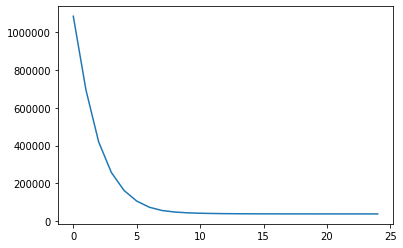

In [18]:
plt.plot(hist_entropia)
plt.show()

Predicción de algunos bigramas en el modelo

In [24]:
test_w = ['pues', 'por', 'par', 'en', 'otra']
print('Predicción de bigramas:')
for w in test_w:
    print(f'  {w} {inv_vocab[modelo.predecir(i_w)]}')

Predicción de bigramas:
  pues vez
  por vez
  par vez
  en vez
  otra vez


### Paso 7. Probabilidad de oraciones.

Calcular la probabilidad de las siguientes oraciones:

- Nos bañamos con agua caliente
- El animalito le olía la cabeza
- Pascuala ordeñaba las vacas

In [37]:
oraciones_test = [
    "Nos bañamos con agua caliente",
    "El animalito le olía la cabeza",
    "Pascuala ordeñaba las vacas",
    "Vaca la pero come dos"
]
test_stems = [
        list(map(lambda token: stemmer_esp.stem(token), # Mapeo cada token a su stem
            re.findall('[a-zA-zñáéíóúü]+', oracion.lower()) # Devuelve una lista con todas las ocurrencias que coincidan con la regex
        ))
        for oracion in oraciones_test
    ]

test_stems

[['nos', 'bañ', 'con', 'agu', 'calient'],
 ['el', 'animalit', 'le', 'oli', 'la', 'cabez'],
 ['pascual', 'ordeñ', 'las', 'vac'],
 ['vac', 'la', 'per', 'com', 'dos']]

In [38]:
# Agrego BOS y EOS
test_stems = [[BOS, *oracion, EOS] for oracion in test_stems]
test_stems

[['<BOS>', 'nos', 'bañ', 'con', 'agu', 'calient', '<EOS>'],
 ['<BOS>', 'el', 'animalit', 'le', 'oli', 'la', 'cabez', '<EOS>'],
 ['<BOS>', 'pascual', 'ordeñ', 'las', 'vac', '<EOS>'],
 ['<BOS>', 'vac', 'la', 'per', 'com', 'dos', '<EOS>']]

Indexo las oraciones de prueba. Si la palabra queda fuera del vocabulario, le asigno el identificador <unk\>

In [39]:
i_UNK = vocab[UNK]
test_corpus_ids = [
    [
        vocab[stem] if vocab[stem]<N else i_UNK # Si la palabra es nueva, uso el indice de <unk>
        for stem in oracion
    ]
    for oracion in test_stems
]
test_corpus_ids

[[0, 93, 19, 80, 390, 34, 1],
 [0, 5, 465, 36, 34, 65, 311, 1],
 [0, 386, 34, 41, 207, 1],
 [0, 207, 65, 2, 56, 114, 1]]

In [40]:
# Saco los bigramas
test_bigramas = [
    [bi for bi in zip(oracion[:-1], oracion[1:])]
    for oracion in test_corpus_ids
]
test_bigramas

[[(0, 93), (93, 19), (19, 80), (80, 390), (390, 34), (34, 1)],
 [(0, 5), (5, 465), (465, 36), (36, 34), (34, 65), (65, 311), (311, 1)],
 [(0, 386), (386, 34), (34, 41), (41, 207), (207, 1)],
 [(0, 207), (207, 65), (65, 2), (2, 56), (56, 114), (114, 1)]]

Calculo las probabilidades de las oraciones.

$$ p(w_1) \prod_{i=1} p(w_{i} | w_{i-1}) $$

In [41]:
def prob_lista_bigramas(lista_bi, A, Pi):
    prob = 1.0
    for w_i, w_j in lista_bi:
        prob *= modelo.forward(w_i)[0][w_j]
    return prob

In [42]:
for lista_bi, oracion in zip(test_bigramas, oraciones_test):
    print(f'Probabilidad de \"{oracion}\" = {prob_lista_bigramas(lista_bi, matA, matPi)}')

Probabilidad de "Nos bañamos con agua caliente" = 6.888483633973914e-21
Probabilidad de "El animalito le olía la cabeza" = 2.6684510596950435e-24
Probabilidad de "Pascuala ordeñaba las vacas" = 2.0989383626948116e-23
Probabilidad de "Vaca la pero come dos" = 5.434131460399946e-37
